In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal

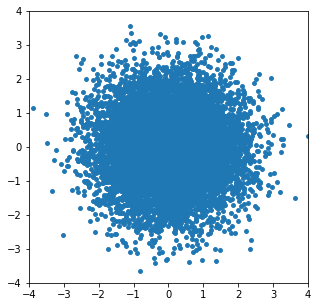

In [2]:
n_sample = 10000
z = MultivariateNormal(torch.zeros(2), torch.eye(2))
sampled_z = z.sample((n_sample,))
plt.figure(figsize = (5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(sampled_z[:,0], sampled_z[:,1], s=15)

In [3]:
def doublemoon_sample(n_sample):
    x1_1 = Normal(4, 4)
    sampled_x1_1 = x1_1.sample((int(n_sample/2),))
    x2_1 = Normal(0.25*(sampled_x1_1-4)**2-20, torch.ones_like(sampled_x1_1)*2)
    sampled_x2_1 = x2_1.sample()

    x1_2 = Normal(-4, 4)
    sampled_x1_2 = x1_2.sample((int(n_sample/2),))
    x2_2 = Normal(-0.25*(sampled_x1_2+4)**2+20, torch.ones_like(sampled_x1_2)*2)
    sampled_x2_2 = x2_2.sample()

    sampled_x1 = torch.cat([sampled_x1_1, sampled_x1_2])
    sampled_x2 = torch.cat([sampled_x2_1, sampled_x2_2])
    sampled_x = torch.zeros(n_sample, 2)
    sampled_x[:,0] = sampled_x1*0.2
    sampled_x[:,1] = sampled_x2*0.1
    
    return sampled_x

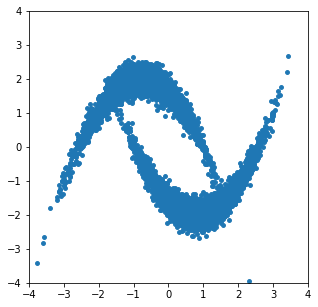

In [4]:
sampled_x = doublemoon_sample(n_sample)
plt.figure(figsize = (5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(sampled_x[:,0],sampled_x[:,1], s=15)

In [5]:
train_loader = DataLoader(sampled_x, batch_size=64, shuffle=True)

In [6]:
class NN(nn.Module):
    def __init__(self, n_input, n_hidden):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3_s = nn.Linear(n_hidden, n_input)
        self.fc3_t = nn.Linear(n_hidden, n_input)
        
    def forward(self, x):
        hidden = F.relu(self.fc2(F.relu(self.fc1(x))))
        s = torch.tanh(self.fc3_s(hidden))
        t = self.fc3_t(hidden)
        return s, t

In [7]:
class RealNVP(nn.Module):
    def __init__(self, n_flows, data_dim, n_hidden):
        super(RealNVP, self).__init__()
        self.n_flows = n_flows
        self.NN = torch.nn.ModuleList()
        
        assert(data_dim % 2 == 0)
        self.n_half = int(data_dim/2)
        
        for k in range(n_flows):
            self.NN.append(NN(self.n_half, n_hidden))
        
    def forward(self, x, n_layers=None):
        if n_layers == None:
            n_layers = self.n_flows
            
        log_det_jacobian = 0
        for k in range(n_layers):
            x_a = x[:, :self.n_half]
            x_b = x[:, self.n_half:]
            
            s, t = self.NN[k](x_a)
            x_b = torch.exp(s)*x_b + t
            
            x = torch.cat([x_b, x_a], dim=1)
            
            log_det_jacobian += s
        
        return x, log_det_jacobian
        
        
    def inverse(self, z, n_layers=None):
        if n_layers == None:
            n_layers = self.n_flows
            
        for k in reversed(range(n_layers)):
            z_a = z[:, self.n_half:]
            z_b = z[:, :self.n_half]
            
            s, t = self.NN[k](z_a)
            z_b = (z_b - t) / torch.exp(s)
            
            z = torch.cat([z_a, z_b], dim=1)
        
        return z

In [8]:
net = RealNVP(4, 2, 256)
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [9]:
n_epochs = 30
for epoch in range(n_epochs):
    running_loss = 0
    for sample_x in train_loader:
        optimizer.zero_grad()
        sample_z, log_det_jacobian = net(sample_x)
        loss = -1 * torch.mean(z.log_prob(sample_z) + log_det_jacobian)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print('epoch:[%2d/%2d] loss:%1.4f' % (epoch+1, n_epochs, running_loss / len(train_loader)))

epoch:[ 1/30] loss:2.9060
epoch:[ 2/30] loss:2.4256
epoch:[ 3/30] loss:2.1690
epoch:[ 4/30] loss:2.0463
epoch:[ 5/30] loss:2.0090
epoch:[ 6/30] loss:1.9619
epoch:[ 7/30] loss:1.9240
epoch:[ 8/30] loss:1.9131
epoch:[ 9/30] loss:1.9114
epoch:[10/30] loss:1.8935
epoch:[11/30] loss:1.8803
epoch:[12/30] loss:1.8704
epoch:[13/30] loss:1.8518
epoch:[14/30] loss:1.8554
epoch:[15/30] loss:1.8852
epoch:[16/30] loss:1.8360
epoch:[17/30] loss:1.8153
epoch:[18/30] loss:1.8171
epoch:[19/30] loss:1.8214
epoch:[20/30] loss:1.7971
epoch:[21/30] loss:1.8079
epoch:[22/30] loss:1.7951
epoch:[23/30] loss:1.8116
epoch:[24/30] loss:1.8103
epoch:[25/30] loss:1.7922
epoch:[26/30] loss:1.7878
epoch:[27/30] loss:1.8016
epoch:[28/30] loss:1.8008
epoch:[29/30] loss:1.7840
epoch:[30/30] loss:1.7959


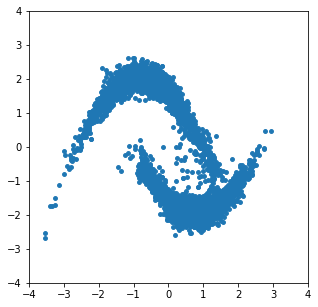

In [10]:
with torch.no_grad():
    new_sampled_z = z.sample((5000,))
    predicted_x = net.inverse(new_sampled_z)
plt.figure(figsize = (5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(predicted_x[:,0], predicted_x[:,1], s=15)

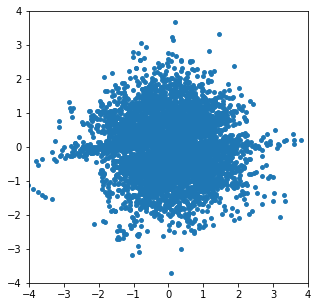

In [11]:
with torch.no_grad():
    new_sampled_x = doublemoon_sample(5000)
    predicted_z, _ = net(new_sampled_x)
plt.figure(figsize = (5,5))
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.scatter(predicted_z[:,0], predicted_z[:,1], s=15)